<a href="https://colab.research.google.com/github/Shankar1302/Shankar1302/blob/main/16june_keras_tf_class2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow House Price Prediction

This is a simple TensorFlow based notebook that applies the steps of the machine learning workflow to create, train, and test a model that will predict house prices.

The notebook:

*  Uses the steps of the machine learning workflow discussed in the course
*  Illustrates how TensorFlow makes it easier to implement a machine learning solution
*  Describes what is happening in various processing steps



## Load correct version of TensorFlow
Before we use TensorFlow we must load the correct version.  We want version 2.x.

In [1]:
# Install TensorFlow using Colab's tensorflow_version command
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Import Libraries

We import TensorFlow, Numpy, and Matplotlib libraries.

Numpy is a powerful n-dimensional array library that
allows us to easily create and manipulate arrays of data, and more!

Numpy also allows us to convert TensorFlow's native data structures,
to Python native data types.

Matplotlib is a graphics plot library

In [2]:
# Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.12.0


## Problem Statement

Using example data, develop a model that predicts house prices based on the size of a house.


## Get Data

In this example we will be using a truncated version of the Ames dataset that only contains information on homes sold in May 2010.

### About the Ames dataset

The Ames dataset is a widely available dataset that has become one of the standard datasets used when
predicting home prices based on features of the home. It is based on the great work of Dean De Cock.  His rational
and insight into this dataset can be found at http://jse.amstat.org/v19n3/decock.pdf.


### Getting the truncated dataset we use
This dataset can be found with the exercise files for this course.  The filename is **AmesHousing-05-2010.csv** .

Before you run the code below, ensure you have downloaded the file to your computer.

And when prompted, browse to the file's location on your computer and upload the file.

*Warning: The file upload function will only show the file selection dialog for 30 seconds.  After that time it will close and cause an error because a file was not specified.  This timeout prevents the file dialog from blocking events in Colab.  If you experience this timeout select the dataset file sooner.  It may help to move the dataset file to an easier to specify location such as your desktop.*



In [ ]:
# You need to upload the file, AmesHousing-05-2001.csv provided with this course
from google.colab import files

# only load the single file
uploaded = files.upload()
# csv_housefile contains the name of the first, and only file uploaded
csv_housefile = next(iter(uploaded.keys()))

print('User uploaded file "{name}" with length {length} bytes'.format(
      name=csv_housefile, length=len(uploaded[csv_housefile])))


### Load the data into a pandas dataframe

Pandas let's us easily review and manipulate the data.  If you are new to pandas, see https://pandas.pydata.org/ and the pandas 10 minute intro  http://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html to understand how pandas, and pandas dataframes makes working with tabular data in Python easy.

In [ ]:
import pandas as pd

# load the housing data into a pandas dataframe for easy viewing and manipulation
df_housing = pd.read_csv(csv_housefile)

### Visualize the House Price data

We use panda's  head method to look at the first few rows of data.  This will give us an understanding of the data we are working with.


In [ ]:
# Visualize the dataset

# turn on option to display all columns, otherwise some columns may be hidden
pd.set_option('display.max_columns', None)
# print the column names and first 5 rows of data
df_housing.head(5)

Lots of feature columns.  From documentation of previous work with this data we can account for most of the difference in price (SalePrice) based on the size of the house.

Looking through the columns we see the following features contains square feet ('SF'): BsmtFin SF 1, BsmtFin SF 2, Bsmt Unf SF, Total Bsmt SF,  1st Flr SF, 2nd Flr SF, Low Qual Fin SF.

A little more checking of the data and we see in the data that there are summary columns for the basement square footage and the above basement square footage.  Specifically the feature columns Total Bsmt SF and Gr Liv Area sum the space as follows:



>  Total Bsmt SF = BsmtFin SF 1 +  BsmtFin SF 2 + Bsmt Unf SF

> Gr Liv Area =  1st Flr SF +  2nd Flr SF

But, there is no feature for the total space in the house which is the sum of Basement and Upper floors or (Total Bsmt SF + Gr Liv Area ).  So let's add a new feature column containing this value called 'Total SF' to the dataset.

But, before we proceed, let's see if the feature columns we are dependent upon contain missing values that will effect our results.  If so, we can remove the rows with missing columns or determine a way of imputing (updating the values) the missing columns.


In [ ]:
 df_housing[['Total Bsmt SF', 'Gr Liv Area']].isnull().values.any()

No missing values, so no additional work is required.  So we can add the new column Total SF.

In [ ]:
# Add new feature column Total SF = Total Bsmt SF + Gr Liv Area
df_housing['Total SF'] = df_housing['Total Bsmt SF'] + df_housing['Gr Liv Area']


And we can check that the numbers add and see associated sale price

In [ ]:
# see the basement and living area, total sf, and price columns
print(df_housing[['Total Bsmt SF', 'Gr Liv Area', 'Total SF', 'SalePrice']].head(5) )

### Visualize the data.

We visualize the data to give us some idea of the relationships between the various features.  To do that we create a  function to plot the data.





In [ ]:
# This function visualizes our data and optionally a learned line
def visualize_data(x_vals, y_vals,
                   addn_x_vals=None, addn_y_vals=None, add_addn_reg_line=False):

  f, ax = plt.subplots(figsize=(8,8))
  plt.plot(x_vals, y_vals, 'ro')   # red dot for each data point
  # Optionally plot another set of data points in a different color and symbol
  if (addn_x_vals is not None):
    plt.plot(addn_x_vals, addn_y_vals, 'g^') # green triangles for additional data points
    # Optionally, plot a regression line.
    if (add_addn_reg_line):
      x_min_index = addn_x_vals.argmin()
      x_max_index = addn_x_vals.argmax()
      print(x_min_index,[addn_x_vals[x_min_index],addn_y_vals[x_min_index]] )
      print(x_max_index,[addn_x_vals[x_max_index],addn_y_vals[x_max_index]] )
      plt.plot([addn_x_vals[x_min_index],addn_y_vals[x_min_index]],
               [addn_x_vals[x_max_index],addn_y_vals[x_max_index]],
               'b-')  # draw a blue regression line

  plt.tick_params(axis='both', which='major', labelsize=14)

  plt.show()  # now plot the line showing the data and the optional line

### Visualizing Total SF and Price

Using the visualize_data function we can see the relationship between Total Square Feet (Total SF) and Price.

In [ ]:
# Plot Total SF vs. Price
visualize_data(df_housing['Total SF'], df_housing['SalePrice'])



### What does the visualization tell us?

There seems to be a **linear** relationship between the size of the house (as shown in Total SF) and Price.

This suggests that we should perform Linear Regression. Where the relationship in the data is:
 y = mx + b.
 Or in our case, Price = m * Total SF + b

With respect to defining the appropriate equation, we can see the difference between traditional programming and Machine Learning as:

* In tradition programming **we define what the equation** is through structures such as conditional statements

* In Machine Learning, our model **learns from the data** what the appropriate equation is.

## Prepare Data

If values are on very different scales it will be difficult for the model to determine the relationships between features.  With our data, Square Footage (SF) ranges from 800-4200, and Prices range from 80,000 to 400,0000.  This means there is a nearly 100 times difference in scale.  When we normalize we will reduce both qualtities to the same scale while preserving the differences between prices and sizes of homes.  This will help our model learn the relationship between price and size.

In [ ]:
# Scale data so SF and Sale Price are on similar scales with values
#  from 0.0 to 1.0

from sklearn.preprocessing import MinMaxScaler

sf_scaler = MinMaxScaler()
sf_scaled = sf_scaler.fit_transform(df_housing['Total SF'].values.reshape(-1,1).astype(np.float64))

price_scaler = MinMaxScaler()
price_scaled = price_scaler.fit_transform(df_housing['SalePrice'].values.reshape(-1,1).astype(np.float64))

## Create Model

Here we create a model to learn from our data.  Our data looks linearly related, so we can use a straight line
to fit our data.  So we are going to create a model that is based on the equation of a straight line.

From our training data we will learn that once we can define this line's parameters we can use it's equation to predict the value of any future data.

We use TensorFlow's Keras library to make the process easy.

We create a sequential model where the output of one layer becomes the input of the next layer.

This model is a simple Neural Network that implements y = wx + bias, where **w is a weight** and **bias is an offset**.

*You may recognize from Algebra or Geometry that y = wx + bias is the equation of straight line, where w is the slope and bias is the offset.  (See https://en.wikipedia.org/wiki/Line_(geometry) for a description.)*

Therefore the goal is to use our data to train the model and learn the best values for w and bias.


### Our Model

We create our linear model using TensorFlow's Keras library.   Using Keras makes it easy for us to create, train, and evaluate our model.



In [ ]:
# Create model using the TensorFlow Keras library
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, activation='linear', input_shape=(1,),
                                kernel_initializer='random_uniform',
                                bias_initializer='zeros'))


### Compile the model

The model is now defined, but is not trained, or even ready to be trained.

We will train the model by passing training data throught it and adjusting the weight and bias to reduce loss (error).  To perform these tasks we need a method for
*  measuring loss and
*  optimizing the values of the weight and bias to minimize this loss.

There are many ways of measuring loss and optimizing the values.  We are going to use **Mean-Squared Error** ('mean_squared_error') to measure loss, and the process of **Stochasitic Gradient Descent** ('sgd') to find the optimal weight and bias to minimize the loss. *Note: We use the variant of sgd called mini-batch gradient descent.  And set the batch size in the fit method below.*

We set these parameters for the model with the **compile** statement.

In [ ]:
# Compile model
optimizer = "sgd"
model.compile(loss='mean_squared_error', optimizer=optimizer )


## Train the Model

Once the model has been defined and compiled we can train the model.  We do this with training data.

We want to split our prepared dataset into 2 datasets.  One dataset will be used for training, and the other dataset will used for testing.  **We never used testing data for training or training data for testing.**

In [ ]:
# Split the dataset into training dataset - 70%, Testing dataset - 30%
# we do this using the sklearn train_test_split method
from sklearn.model_selection import train_test_split

sf_train_scaled, sf_test_scaled, price_train_scaled, price_test_scaled = train_test_split(sf_scaled,
                                                    price_scaled,
                                                    test_size=0.3, random_state=42)

We pass the training data through the model multiple times.  On each pass, the loss function (that we defined in the model compile) will be used to calculate loss.  And the optimizer will be used to make adjustments to the weights and bias (just called weights from here on) to minimize this error.

We repeat this process of calculating the loss with the current weights and updating the weights to minimize loss for the specified number of **epochs**.  *We should see the loss decrease over time.*

We can set the *verbose* flag to tell Keras how much information to show during the training process, 0 is none, 1 and 2 show more in-progress information.

In [ ]:

# Train model using data
initial_epochs = 8
batch_size = 10
train_hist = model.fit(sf_train_scaled, price_train_scaled,
                       epochs=initial_epochs, batch_size=batch_size, verbose=1)

# Is 8 epochs enough??? Maybe/Maybe not

### Visually Confirm Model Training

Our model learned the best weight and bias for our training data that it could through the defined number of epochs.  Let's see if a line drawn with the learned weight and bias looks reasonable.

In [ ]:

#  predict the price with our trained model
price_predicted_scaled =  model.predict(sf_train_scaled)
visualize_data(sf_scaler.inverse_transform(sf_train_scaled), price_scaler.inverse_transform(price_train_scaled),
               sf_scaler.inverse_transform(sf_train_scaled), price_scaler.inverse_transform(price_predicted_scaled),
               add_addn_reg_line=False)

# If line looks bad, what do we do?

### Evaluate Training


Our trained model does not looks too good !!!

What can we do?

Should we change model architecture?  Does linear look incorrect?

> NO


What does loss look like?


In [ ]:
def plot_loss(hist):
  # plot the loss
  plt.title('Loss History')
  plt.plot(hist.history['loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.show()

print(type(train_hist))
plot_loss(train_hist)



> LOSS STILL LOOKS HIGH.  BUT IS DECREASING.



Perhaps we have not converged to the lowest loss.  What can we do????

Train with more data?

> NO.  WE HAVE ALL THE DATA

Train for more epochs and check loss to ensure values have converged?
 > YES!!!

### Training more epochs

The model is partially trained but the results are not great.  Let's go back and train the model some more.

The question is how much more?

We want to ensure the model is converged to a range of loss values.   So what we will see in the training output is the loss value starts to stay in a specific range .   It may go up or down a little, but there should be a stable range.

In [ ]:
# Train model using data.  This time, train for additional epochs
# Also capture the changes over time in the history variable, train_hist_addn so we
#   can see if loss is converging
addn_epochs = 1200
train_hist_addn =model.fit(sf_train_scaled, price_train_scaled,
                     epochs=addn_epochs, verbose=1)

Plot the loss history values to see if our model converged.

Because a model can have a history of many  different metrics over time, there is a history object which has a keys dictionary of
metrics whose values were stored on each epoch. By plotting the values for the 'loss' key we can answer:


1.   Did the loss converge?
2.   How many epochs were required for the loss to converge?



In [ ]:
# add the addition epochs to the  training history
train_hist.history['loss'].extend(train_hist_addn.history['loss'])
plot_loss(train_hist)

### Visually Confirm Model after Additional Training

As the  plot showed, the model's loss converged by 1000 epochs.  So the model should be trained to allow us to make accurate predictions.

Let's again plot the predicted price for each size.  And see if a line drawn with the learned weight and bias looks reasonable.


In [ ]:
# Visualize data and regression line for learned weights
price_predicted_scaled =  model.predict(sf_train_scaled)
visualize_data(sf_scaler.inverse_transform(sf_train_scaled),
               price_scaler.inverse_transform(price_train_scaled),
               sf_scaler.inverse_transform(sf_train_scaled),
               price_scaler.inverse_transform(price_predicted_scaled),
               add_addn_reg_line=False)


**Yes.  The predicted line looks good!!!**

## Evaluate Trained Model

Once we have the model trained, we want to test **with data not used to train the model!!!**

The use of data not used in training to test the model is key.  If you use training data our testing results will be overly accurate and will not reflect *real-life* usage of the trained model to make predictions.

In [ ]:
# Make a price prediction on data the model has never seen before, i.e.
#    the Test data square footage
price_test_pred_scaled = model.predict(sf_test_scaled)

# calculate the mean squared error for the prediction, lower is better
from sklearn.metrics import mean_squared_error
print("prediction mean squared error:",
          mean_squared_error(price_test_scaled, price_test_pred_scaled ))

# Visualize data
#    plus the test square footage and predicted price
print('\nGreen triangles are Test square footage with predicted Price')
visualize_data(sf_scaler.inverse_transform(sf_test_scaled),
               price_scaler.inverse_transform(price_test_scaled),
               sf_scaler.inverse_transform(sf_test_scaled),
               price_scaler.inverse_transform(price_test_pred_scaled),
               add_addn_reg_line=False)
print('\nOur predicted values fit the data well!')

## What we have learned



*   In Machine Learning we often spend considerable effort getting data in a form that our models can learn from the data.
* A single neuron model can learn the appropriate slope and offset for the data.
*   Building this model was made easier by TensorFlow's implementation of the Keras library.
*   But to learn from the data we need to pass the data through the model enough times to get the loss to converge.
*   When we do that, the model learns the data's slope and offset more accurately.
*  And when we apply these learned values, the predict prices from the test data's square footage are reasonable.



# Fashion-MNIST Neural Network

This notebook implements a simple NN consisting of two dense layers, and uses this network to classify Fashion-MNIST images.

These Fashion-MNIST images consist of clothing items from these ten classes. (*T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot)*

![image.png](attachment:image.png)

## Load correct version of TensorFlow

Before we use TensorFlow we must load the correct version. We want version 2.x. To do this we execute the Colab commands below. Note that these commands ONLY WORK IN COLAB.

![image.png](attachment:image.png)

![image.png](attachment:image.png)

![image.png](attachment:image.png)

![image.png](attachment:image.png)

![image.png](attachment:image.png)

![image.png](attachment:image.png)

![image.png](attachment:image.png)

In [ ]:
# Install TensorFlow using Colab's tensorflow_version command
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


## Import Libraries

We import TensorFlow, Numpy, and Matplotlib libraries.

Numpy is a powerful n-dimensional array library that
allows us to easily create and manipulate arrays of data, and more!

Numpy also allows us to convert TensorFlow's native data structures,
to Python native data types.

Matplotlib is a graphics plot library

In [ ]:
# Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

## Problem Statement

Using example data, train a model that will correctly predict the class of images of fashion items.



## Get Data

### About the Fashion-MNIST dataset

The Fashion-MNIST dataset is a widely available dataset.  It is documented at the https://github.com/zalandoresearch/fashion-mnist

Each image in the dataset is 28 X 28 pixels.  The pixel values are a grayscale with values ranging from 0 to 255.

Associated with each image is a number from 0 to 9 specifying the class of the fashion item in the image.  The values for the classes are:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
|   1    | Trouser    |
|  2     |  Pullover  |
|   3    |    Dress    |
|    4   |    Coat      |
|   5    | Sandal     |
|   6    | Shirt         |
|    7   |  Sneaker  |
|   8    |  Bag          |
|  9     | Ankle boot |

There are 60,000 Training examples and 10,000 Testing examples.

We will need these class names later in the code.  So we create an list of names we can index by the class label number.  For example, class_names[2] = 'Pullover' and class_names[9] = 'Ankle boot'.

In [4]:
# Define class names to display
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                  'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Fashion-MNIST is one of the datasets provided with Keras in Tensorflow.  Keras' Dataset library provides a load_data() method that will download the dataset of 60,000 Training images and their corresponding 60,000 labels, and 10,000 Test images and their corresponding 10,000 labels.

In [5]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


4422102/4422102 [==============================] - 1s 0us/step


### Explore the data

Let's look at our data.

In [6]:
# Print the shape of the data tensors we loaded.  Should be:
#   60,000 training 28X28 images and their labels, and 10,000 testing images and their labels
print ('Training data:', train_images.shape, train_labels.shape)
print ('Test data:', test_images.shape, test_labels.shape)

Training data: (60000, 28, 28) (60000,)
Test data: (10000, 28, 28) (10000,)


### Inspect data
Each image should be a 28 X 28 image and have a gray scale value of 0-255. Let's display an arbitrary image.

You should see:
* A title that specifies the class of the image, whose description is shown on the table above.
* The image
* The 28 by 28 width and height pixel index
* and on the right the grayscale legend associated with the pixel values.

In [7]:
def show_training_image(index):
  img_label = str(train_labels[index]) + ' (' +  class_names[train_labels[index]] + ')'
  plt.figure()
  plt.title('Image Label ' + img_label)
  plt.imshow(train_images[index], cmap='gray')  # data is grayscale, but displays in color without cmap='gray'
  plt.colorbar()
  plt.show()


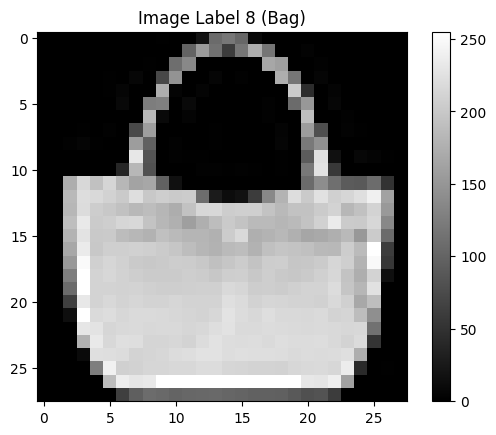

In [8]:
img_index = 100
show_training_image(img_index)

## Prepare Data

As usual we need to do some pre-processing of the data.  Here we want to scale the pixels values from 0 to 255 to 0.0 to 1.0.  We scale both the training and testing image values.

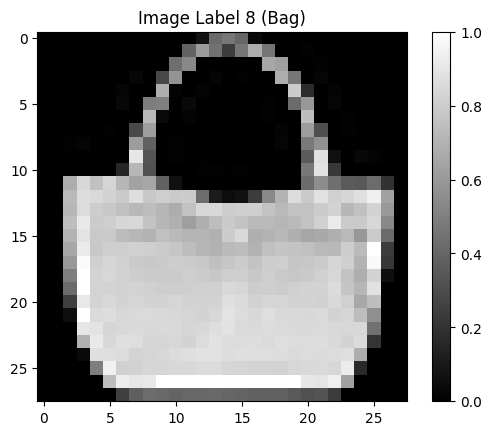

In [9]:
# scale training and testing image values
train_images = train_images / 255.0
test_images = test_images / 255.0

# Print the image again and notice the values now range from 0 to 1.
#   And the image looks the same, just on a different scale.
show_training_image(img_index)

## Create Model

We can now create the model we are going to train with the data.

This will be a simple model that:
* Flattens the 28 X 28 pixel values into a long stream of 28 by 28 = 784 pixel values - Note this is a Keras layer but is not a neural network layer. Notice the input_shape parameter contains only the shape of a single data element.  There are n data elements each with this same shape.
* Passes each pixel value as the input to each of the 128 neurons.
* And finally passes values to the last layer that contains 10 neurons, one for each of the ten classes (t-shirt, pullover, etc).  Each of these 10 neurons uses the Softmax activation function to determine the probability that the image is each class.  The final output from the model is a vector of probabilities that the image is of each class.  Such as :
[0.01, 0.05, 0.04, 0.06, 0.50, 0.20, 0.04, 0.00, 0.03, 0.07].  This example vector adds up to 1.0 and shows the probability that the image is class 0 (T-shirt/top) is 0.01 (1%), class 1 (Trousers) is 0.05 (5%), class 2 (Pullover) is 0.04 (4%), ....


In [10]:

model = tf.keras.models.Sequential()      # Create a new sequential model
model.add(tf.keras.layers.Flatten(input_shape=(28,28)))    # keras processing layer - no neurons
model.add(tf.keras.layers.Dense(128, activation='relu', name='dense-128-relu'))   # 128 neurons connected to pixels
model.add(tf.keras.layers.Dense(10, activation='softmax', name='dense-10-softmax')) # determines probability of each of the 10 classes


### Structure of the model

To make it easy for us to visualize the model, Keras models have a summary method.  When we call it we see our model structure.

For completeness we also show the shape of the input data.


In [11]:
print('Input Shape:', train_images.shape)
print()
print(model.summary())

Input Shape: (60000, 28, 28)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense-128-relu (Dense)      (None, 128)               100480    
                                                                 
 dense-10-softmax (Dense)    (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


### Compile the model

Before we can train the model we need to specify how the model will learn from the training data.  To do this we specify:
*  loss - how we measure loss (error).  We will use sparse_categorical_crossentropy, which determines the highest predicted class and calculates loss based on how often this is the correct class.
*     optimizer - how the model will update the model's weights to reduce the loss.  We use the Adam variant of Mini-batch Gradient Descent.
* metrics  - the metrics used for evaluation of training and test.  In this case we use accuracy, that is how often the images are correctly classified.  Higher is better. (1.00 would be perfect (100%), 0,75 = 75%, 0.25 = 25%, ...)


In [12]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


## Train the Model
Now that we have our data and model, and have specified how the model will learn from the data we can train it.

In [13]:
train_hist = model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 11s 2ms/step - loss: 0.4925 - accuracy: 0.8268
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3660 - accuracy: 0.8677
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3335 - accuracy: 0.8780
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3095 - accuracy: 0.8863
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2910 - accuracy: 0.8928


Plot the training to makes sure it is converging.

In [ ]:
def plot_acc(hist):
  # plot the accuracy
  plt.title('Accuracy History')
  plt.plot(hist.history['accuracy'])
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.show()

def plot_loss(hist):
  # plot the loss
  plt.title('Loss History')
  plt.plot(hist.history['loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.show()



In [ ]:
plot_loss(train_hist)
plot_acc(train_hist)

## Evaluate Trained Model

Once we have the model trained, we need to see how it will perform on data that it was not trained on, that is, test data.

We do this with Keras' evaluation function and the test dataset we retrieved earlier.


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)

print('max training accuracy:', max(train_hist.history['accuracy']), '  test accuracy:', test_acc)

## Training Results

The model has **about 96% accuracy** on the training data.  And **only 88% accuracy** on testing data on which it was not trained. This is a classic sign that the model overfits the training data.

We need to determine how we can reduce this overfitting and get **good accuracy on both training and test data!**




# Monitoring and Improving our Trained Model’s Performance

In this section, we want to make changes to improve the performance of our trained model.  By improved performance we mean having the model not overfit the training data and perform poorly on the testing data.

There are serveral common techniques to fix this problem.  These include:

1.   Reducing Model Complexity - removing neurons or layers
2.   Dropout - Randomly removing the contributions from some neurons
3.   Early Stopping - Terminating training as early as possible

We will try these below.



## Monitoring performance with TensorBoard

We want to ensure we are getting good data to evaluate the performance of our changes.  Fortunately the TensorFlow family include the tool **TensorBoard**.

TensorBoard provides us various ways to monitor the performance of our models including:

*    Visualizing metrics such as loss and accuracy
*    Comparision of training and evaluation metrics
*    Visualizing the model graph (ops and layers)
*    Viewing histograms of weights, biases, or other tensors as they change over time


TensorBoard can be run inside a Colab notebook, or if you are running your code directly in Python you can invoke TensorBoard from the command line.

In [ ]:
import datetime

In [ ]:
# Load the tensorboard extension
% reload_ext tensorboard

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
# Start with a fresh model
model = tf.keras.models.Sequential()      # Create a new sequential model
model.add(tf.keras.layers.Flatten(input_shape=(28,28)))    # keras processing layer - no neurons
model.add(tf.keras.layers.Dense(128, activation='relu', name='dense-128-relu'))   # 128 neurons connected to pixels
model.add(tf.keras.layers.Dense(10, activation='softmax', name='dense-10-softmax')) # determine probability of each of the 10 classes

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


log_dir='logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# We add to the fit method the validation/test data.  This will cause the training model
# to evaluate itself on the validation/test data on each epoch.  This provides per
# epoch data points TensorBoard can plot so we can see the trend.
train_hist = model.fit(train_images, train_labels, epochs=40,
                       validation_data=(test_images, test_labels),
                        callbacks=[tensorboard_callback])



In [ ]:
#!kill 1234   # sometime TensorBoard does not show all data.  If it shows reusing previous instance use kill command listed
%tensorboard --logdir logs/fit

## Fixing Fashion MNIST

### Reducing Model Complexity

In a large model we can consider reducing the number of hidden layers.  But our model only has one hidden layer and we need it.  So the only thing to do is reduce the number of neurons in the hidden layer.  Everthing else is the same
as above.

In [ ]:
# Load the tensorboard extension
% reload_ext tensorboard

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:

model = tf.keras.models.Sequential()      # Create a new sequential model
model.add(tf.keras.layers.Flatten(input_shape=(28,28)))    # keras processing layer - no neurons
model.add(tf.keras.layers.Dense(64, activation='relu', name='dense-64-relu'))   # 64 neurons connected to pixels
#model.add(tf.keras.layers.Dense(128, activation='relu', name='dense-128-relu'))   # 128 neurons connected to pixels
model.add(tf.keras.layers.Dense(10, activation='softmax', name='dense-10-softmax')) # determine probability of each of the 10 classes

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


log_dir= 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# We add to the fit method the validation/test data.  This will cause the training model
# to evaluate itself on the validation/test data on each epoch.  This provides per
# epoch data points TensorBoard can plot so we can see the trend.
train_hist = model.fit(train_images, train_labels, epochs=40,
                       validation_data=(test_images, test_labels),
                        callbacks=[tensorboard_callback])



Show the results with TensorBoard

In [ ]:
#!kill 1234   # sometime TensorBoard does not show all data.  If it shows reusing previous instance use kill command listed
%tensorboard --logdir logs/fit

### Randomly dropout some neurons

To randomly shut down the contribution from some neurons, we add a Keras dropout layer.  This layer randomly sets the outputs from the previous layer to 0.  How many outputs are set to 0 is defined by the parameter we pass.  To set 50% of
the outputs to 0 pass 0.5.  For 20% pass 0.2.

Also, the decision on which connections get dropped is a random selection that
changes from epoch to epoch.

In [ ]:
# Load the tensorboard extension
% reload_ext tensorboard

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
model = tf.keras.models.Sequential()      # Create a new sequential model
model.add(tf.keras.layers.Flatten(input_shape=(28,28)))    # keras processing layer - no neurons
model.add(tf.keras.layers.Dense(128, activation='relu', name='dense-128-relu'))   # 128 neurons connected to pixels
model.add(tf.keras.layers.Dropout(0.2))  # dropout 20%
model.add(tf.keras.layers.Dense(10, activation='softmax', name='dense-10-softmax')) # determine probability of each of the 10 classes

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
log_dir='logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=train_images,
          y=train_labels,
          epochs=40,
          validation_data=(test_images, test_labels),
          callbacks=[tensorboard_callback])


In [ ]:
#!kill 1234   # sometime TensorBoard does not show all data.  If it shows reusing previous instance use kill command listed
%tensorboard --logdir logs/fit

### Implementing Early Stopping

Early stopping involves having the training stop when the model has been trained enough.

Often training is slow in terms of time, and expensive in terms of compute time on big clusters or a cloud service.  So it is useful to be able to stop training as soon as reasonable.  And reasonable is usually when the metric like lose quits decreasing.  So the question is, how can we know when the loss quits decreasing?

We could run a bunch of trials and use a tool like TensorBoard to plot curves.  But it is tedious to write a model with 20 epochs, run it, see loss was decreasing, then repeat that with 40 epochs, etc.  Worse, if we change the model or it's parameters, like adjusting the dropout percentage, the number of epochs required to see when the loss stops decreasing might be different.

So what we need is an automated way to detect when training has quit improving and terminate training.  And fortunately Keras has an early stopping feature that does just this!

We start with the same model, optimizer, loss, and log clearing code as before.

In [ ]:
# Load the tensorboard extension
% reload_ext tensorboard

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
model = tf.keras.models.Sequential()      # Create a new sequential model
model.add(tf.keras.layers.Flatten(input_shape=(28,28)))    # keras processing layer - no neurons
model.add(tf.keras.layers.Dense(128, activation='relu', name='dense-128-relu'))   # 128 neurons connected to pixels
model.add(tf.keras.layers.Dense(10, activation='softmax', name='dense-10-softmax')) # determine probability of each of the 10 classes

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

We create a new EarlyStopping callback.

And we set the **monitor** parameter to the parameter to monitor, which is **validation loss**. And the  **patience** parameter to the maximum number of epochs without improvement allowed.  And if the parameter does not improve within the patience number of epochs, the training will be terminated.

This new callback gets added to the list of callbacks.

In [ ]:
log_dir='logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

model.fit(x=train_images,
          y=train_labels,
          epochs=40,
          validation_data=(test_images, test_labels),
          callbacks=[tensorboard_callback, early_stopping_callback])


In [ ]:
#!kill 1234   # sometime TensorBoard does not show all data.  If it shows reusing previous instance use kill command listed
%tensorboard --logdir logs/fit

## Save Your Model

Now that we have our model working well.  We can save it for reuse.

By saving the model's structure and the associated trained weights we preserve our work.  Those weights are well over 101,000 values for which we had to work hard to get to the proper numbers!!


In [17]:
# We use the Python tempfile library to create files in a generated folder.
# If you want to used a defined path, replace this code with your own
# path definitions.
import tempfile
import os

# get the tempfile location for this Colab session
MODEL_DIR = tempfile.gettempdir()
version = 1   # NOTE: Adjust if you don't want to replace a version of your model
export_path = os.path.join(MODEL_DIR, str(version))  # the final path includes the version
print('Saving model to : {}\n'.format(export_path))

# if path already exists delete everything at the location
if os.path.isdir(export_path):
  print('\nPreviously saved model found, deleting it\n')
  !rm -r {export_path}

# Save the model
tf.saved_model.save(model, export_path)

# Print save complete message
print('Model saved')


Saving model to : /tmp/1

Model saved




# Deploying our Trained Model

Once we are satisified with the model's performance we can deploy it so other programs can use it.  This is a complex subject since the deployment strategies depend on how our model will be used.

In this script we will show a very basic way of deploying the model.  We will do just enough so we can make predictions with our trained model from Python.



## TensorFlow ModelServer

We are going to use the Tensorflow ModelServer to serve our model.  This install may only work in Colab.

*The recommendation for general installation and usage of the server is to use a docker container.  This is documented in the repo, https://github.com/tensorflow/serving/blob/master/tensorflow_serving/g3doc/setup.md*

## Add TensorFlow Serving as installable

Before we can install the TensorFlow ModelServer we need to make it known to the APT installer so the installer know where to fetch the bits.

We do this by adding a key in to the APT database refering to the tensorflow-serving files location.

In [14]:
# add the key
!echo 'deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal' | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
# update the database with the new key
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  18626      0 --:--:-- --:--:-- --:--:-- 18626
OK
Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-back

### Install TensorFlow ModelServer

We use apt-get to fetch and install TensorFlow ModelServer

In [15]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 430 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.12.1 [430 MB]
Fetched 430 MB in 15s (28.6 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 123069 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.12.1_all.deb ...
Unpacking tensorflow-model-server (2.12.1) ...
Setting up tensorflow-model-server (2.12.1) ...


### Start TensorFlow ModelServer

This is where we start TensorFlow ModelServer and load our model.  After it loads we can start making inference requests using REST.  There are some important parameters:

* `rest_api_port`: The port that you'll use for REST requests.
* `model_name`: You'll use this in the URL of the REST requests.  It can be anything.
* `model_base_path`: This is the path to the directory where you've saved your model.

We need to define these as Python variables and as shell environment variables.  This will make this information available in Python code and in
the shell where we will start the TensorFlow ModelServer process.

In [18]:
# Define the environment variable where our saved model resides
os.environ['MODEL_DIR'] = MODEL_DIR
# Define the Python constant and environment variable to point to the port number used to access our model
REST_PORT = '8501'
os.environ['REST_PORT'] = REST_PORT
# Define the Python constant and environment variable to point to the our model name.
#  This is an abitrary name.
MODEL_NAME = 'fashion_mnist'
os.environ['MODEL_NAME'] = MODEL_NAME

In [19]:
# Run the shell command to launch tensorflow_model_server.  Output status and error
#  messages to the file server.log
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port="${REST_PORT}" \
  --model_name="${MODEL_NAME}" \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


In [20]:
# Display the tail (last few lines) of the server log which will show any errors
!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


### Function to display image with user defined title

In [21]:
def show_image(index, title, show_colorbar=False):
  plt.figure()
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})
  plt.imshow(test_images[index].reshape(28,28), cmap='gray')  # data is grayscale, but displays in color without cmap='gray'
  if (show_colorbar):
    plt.colorbar()
  plt.axis('off')
  plt.show()




## Make a REST request to predict class of our example image




In [22]:
!pip install -q requests    # Install the requests library which makes HTTP requests to the TensorFlow server
                            # using our trained our model
import requests     # import requests

In [23]:
# Select a random image to classify
import random
image_index = random.randint(0,len(test_images)-1)


In [24]:
 # Import json library and create the json data structure to be passed in the request.
import json

# The data is assumed to be a list of images, a 4D tensor of the shape [*,28,28,1].
# Convert the single 3d to 4d
check_images = np.reshape(test_images[image_index],(-1,28,28,1))

# Construct json data passed to server.  "instances" will hold the image(s) we
#   want the model to classify
data = json.dumps({'signature_name': 'serving_default', 'instances': check_images.tolist()})

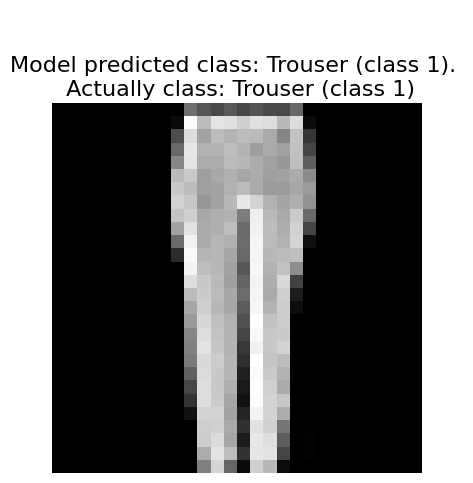

In [25]:
# Create the request

# HTTP request header
headers = {'content-type': 'application/json'}

# Build the url to the service using the constants we defined earlier, should be of the form:
#      http://localhost:8501/v1/models/fashion_mnist:predict
predict_service_url = 'http://localhost:' + REST_PORT + '/v1/models/' + MODEL_NAME + ':predict'

# Make request to the service.  Pass the headers and data.  Wait for the server's reponse.
json_response = requests.post(predict_service_url, data=data, headers=headers)

# Parse the response.  For each images we pass we get a list of probabilities
predictions = json.loads(json_response.text)['predictions']
# predictions[0] is the 10 probabilites for our first and only image.
# predictions[0] has values in the form [0.1, 0.05, ...., 0.6]

# The numpy argmax function returns the index of the highest value.  This is
# the highest probabilty class predicted by our model.
predicted_class = np.argmax(predictions[0])

# Display image, the actual class and the predicted class
show_image(image_index, 'Model predicted class: {} (class {}). \n Actually class: {} (class {})'.format(
  class_names[predicted_class], predicted_class, class_names[test_labels[image_index]], test_labels[image_index]))

## BUilding NN as a Functional API with keras

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 Hidden-1 (Dense)            (None, 4)                 12        
                                                                 
 Hidden-2 (Dense)            (None, 4)                 20        
                                                                 
 Output_layer (Dense)        (None, 1)                 5         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
19/22 [========================>.....] - ETA: 0s - loss: 0.6942 - accuracy: 0.5477 

22/22 [==============================] - 1s 13ms/step - loss: 0.6932 - accuracy: 0.5443 - val_loss: 0.6756 - val_accuracy: 0.6467
Epoch 2/100
19/22 [========================>.....] - ETA: 0s - loss: 0.6638 - accuracy: 0.6086

22/22 [==============================] - 0s 5ms/step - loss: 0.6642 - accuracy: 0.6043 - val_loss: 0.6414 - val_accuracy: 0.6567
Epoch 3/100
20/22 [==========================>...] - ETA: 0s - loss: 0.6127 - accuracy: 0.6625

22/22 [==============================] - 0s 5ms/step - loss: 0.6086 - accuracy: 0.6743 - val_loss: 0.5618 - val_accuracy: 0.8033
Epoch 4/100
19/22 [========================>.....] - ETA: 0s - loss: 0.5104 - accuracy: 0.8010

22/22 [==============================] - 0s 5ms/step - loss: 0.4957 - accuracy: 0.8200 - val_loss: 0.4359 - val_accuracy: 0.9033
Epoch 5/100
17/22 [======================>.......] - ETA: 0s - loss: 0.3794 - accuracy: 0.8676

22/22 [==============================] - 0s 5ms/step - loss: 0.3842 - accuracy: 0.8571 - val_loss: 0.3197 - val_accuracy: 0.8933
Epoch 6/100
19/22 [========================>.....] - ETA: 0s - loss: 0.2625 - accuracy: 0.9293

22/22 [==============================] - 0s 5ms/step - loss: 0.2582 - accuracy: 0.9286 - val_loss: 0.2623 - val_accuracy: 0.9167
Epoch 7/100
13/22 [================>.............] - ETA: 0s - loss: 0.2029 - accuracy: 0.9423

22/22 [==============================] - 0s 6ms/step - loss: 0.1926 - accuracy: 0.9471 - val_loss: 0.2213 - val_accuracy: 0.9333
Epoch 8/100
19/22 [========================>.....] - ETA: 0s - loss: 0.1540 - accuracy: 0.9523

22/22 [==============================] - 0s 5ms/step - loss: 0.1490 - accuracy: 0.9571 - val_loss: 0.1634 - val_accuracy: 0.9567
Epoch 9/100
19/22 [========================>.....] - ETA: 0s - loss: 0.1310 - accuracy: 0.9622

22/22 [==============================] - 0s 5ms/step - loss: 0.1281 - accuracy: 0.9629 - val_loss: 0.1422 - val_accuracy: 0.9533
Epoch 10/100
19/22 [========================>.....] - ETA: 0s - loss: 0.0995 - accuracy: 0.9720

22/22 [==============================] - 0s 5ms/step - loss: 0.1053 - accuracy: 0.9700 - val_loss: 0.2002 - val_accuracy: 0.9067
Epoch 11/100
19/22 [========================>.....] - ETA: 0s - loss: 0.1549 - accuracy: 0.9424

22/22 [==============================] - 0s 5ms/step - loss: 0.1486 - accuracy: 0.9457 - val_loss: 0.1488 - val_accuracy: 0.9400
Epoch 12/100
16/22 [====================>.........] - ETA: 0s - loss: 0.1061 - accuracy: 0.9590

22/22 [==============================] - 0s 5ms/step - loss: 0.0993 - accuracy: 0.9629 - val_loss: 0.1458 - val_accuracy: 0.9567
Epoch 13/100
19/22 [========================>.....] - ETA: 0s - loss: 0.0889 - accuracy: 0.9688

22/22 [==============================] - 0s 5ms/step - loss: 0.0958 - accuracy: 0.9614 - val_loss: 0.1286 - val_accuracy: 0.9567
Epoch 14/100
17/22 [======================>.......] - ETA: 0s - loss: 0.1020 - accuracy: 0.9559

22/22 [==============================] - 0s 5ms/step - loss: 0.1187 - accuracy: 0.9529 - val_loss: 0.1627 - val_accuracy: 0.9400
Epoch 15/100
20/22 [==========================>...] - ETA: 0s - loss: 0.1126 - accuracy: 0.9578

22/22 [==============================] - 0s 6ms/step - loss: 0.1170 - accuracy: 0.9557 - val_loss: 0.1949 - val_accuracy: 0.9000
Epoch 16/100
20/22 [==========================>...] - ETA: 0s - loss: 0.0984 - accuracy: 0.9719

22/22 [==============================] - 0s 5ms/step - loss: 0.0952 - accuracy: 0.9729 - val_loss: 0.1222 - val_accuracy: 0.9533
Epoch 17/100
19/22 [========================>.....] - ETA: 0s - loss: 0.0852 - accuracy: 0.9688

22/22 [==============================] - 0s 5ms/step - loss: 0.0855 - accuracy: 0.9686 - val_loss: 0.1482 - val_accuracy: 0.9367
Epoch 18/100
19/22 [========================>.....] - ETA: 0s - loss: 0.0803 - accuracy: 0.9753

22/22 [==============================] - 0s 5ms/step - loss: 0.0785 - accuracy: 0.9757 - val_loss: 0.1122 - val_accuracy: 0.9600
Epoch 19/100
19/22 [========================>.....] - ETA: 0s - loss: 0.0702 - accuracy: 0.9737

22/22 [==============================] - 0s 5ms/step - loss: 0.0702 - accuracy: 0.9729 - val_loss: 0.1401 - val_accuracy: 0.9333
Epoch 20/100
19/22 [========================>.....] - ETA: 0s - loss: 0.0783 - accuracy: 0.9720

22/22 [==============================] - 0s 5ms/step - loss: 0.0772 - accuracy: 0.9729 - val_loss: 0.1251 - val_accuracy: 0.9567
Epoch 21/100
19/22 [========================>.....] - ETA: 0s - loss: 0.0704 - accuracy: 0.9753

22/22 [==============================] - 0s 6ms/step - loss: 0.0730 - accuracy: 0.9714 - val_loss: 0.1133 - val_accuracy: 0.9533
Epoch 22/100
17/22 [======================>.......] - ETA: 0s - loss: 0.0640 - accuracy: 0.9779

22/22 [==============================] - 0s 6ms/step - loss: 0.0628 - accuracy: 0.9771 - val_loss: 0.1164 - val_accuracy: 0.9500
Epoch 23/100
19/22 [========================>.....] - ETA: 0s - loss: 0.0656 - accuracy: 0.9720

22/22 [==============================] - 0s 7ms/step - loss: 0.0618 - accuracy: 0.9743 - val_loss: 0.1307 - val_accuracy: 0.9433
Epoch 24/100
19/22 [========================>.....] - ETA: 0s - loss: 0.0742 - accuracy: 0.9688

22/22 [==============================] - 0s 5ms/step - loss: 0.0742 - accuracy: 0.9686 - val_loss: 0.1221 - val_accuracy: 0.9533
Epoch 25/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0746 - accuracy: 0.9757

22/22 [==============================] - 0s 5ms/step - loss: 0.0794 - accuracy: 0.9743 - val_loss: 0.1379 - val_accuracy: 0.9467
Epoch 26/100
15/22 [===================>..........] - ETA: 0s - loss: 0.0879 - accuracy: 0.9646

22/22 [==============================] - 0s 6ms/step - loss: 0.0951 - accuracy: 0.9629 - val_loss: 0.1267 - val_accuracy: 0.9400
Epoch 27/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0761 - accuracy: 0.9722

22/22 [==============================] - 0s 5ms/step - loss: 0.0728 - accuracy: 0.9757 - val_loss: 0.1723 - val_accuracy: 0.9300
Epoch 28/100
19/22 [========================>.....] - ETA: 0s - loss: 0.0773 - accuracy: 0.9720

22/22 [==============================] - 0s 5ms/step - loss: 0.0809 - accuracy: 0.9700 - val_loss: 0.1138 - val_accuracy: 0.9600
Epoch 29/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0718 - accuracy: 0.9740

22/22 [==============================] - 0s 5ms/step - loss: 0.0675 - accuracy: 0.9743 - val_loss: 0.1508 - val_accuracy: 0.9500
Epoch 30/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0820 - accuracy: 0.9705

22/22 [==============================] - 0s 5ms/step - loss: 0.0855 - accuracy: 0.9657 - val_loss: 0.1237 - val_accuracy: 0.9533
Epoch 31/100
20/22 [==========================>...] - ETA: 0s - loss: 0.0766 - accuracy: 0.9703

22/22 [==============================] - 0s 5ms/step - loss: 0.0817 - accuracy: 0.9643 - val_loss: 0.1147 - val_accuracy: 0.9567
Epoch 32/100
13/22 [================>.............] - ETA: 0s - loss: 0.0614 - accuracy: 0.9808

22/22 [==============================] - 0s 9ms/step - loss: 0.0716 - accuracy: 0.9729 - val_loss: 0.1199 - val_accuracy: 0.9500
Epoch 33/100
13/22 [================>.............] - ETA: 0s - loss: 0.0603 - accuracy: 0.9736

22/22 [==============================] - 0s 9ms/step - loss: 0.0746 - accuracy: 0.9729 - val_loss: 0.1168 - val_accuracy: 0.9667
Epoch 34/100
14/22 [==================>...........] - ETA: 0s - loss: 0.0581 - accuracy: 0.9799

22/22 [==============================] - 0s 9ms/step - loss: 0.0660 - accuracy: 0.9743 - val_loss: 0.1242 - val_accuracy: 0.9433
Epoch 35/100
19/22 [========================>.....] - ETA: 0s - loss: 0.0676 - accuracy: 0.9770

22/22 [==============================] - 0s 11ms/step - loss: 0.0718 - accuracy: 0.9729 - val_loss: 0.1301 - val_accuracy: 0.9533
Epoch 36/100
13/22 [================>.............] - ETA: 0s - loss: 0.0673 - accuracy: 0.9736

22/22 [==============================] - 0s 9ms/step - loss: 0.0820 - accuracy: 0.9700 - val_loss: 0.1376 - val_accuracy: 0.9333
Epoch 37/100
14/22 [==================>...........] - ETA: 0s - loss: 0.0713 - accuracy: 0.9665

22/22 [==============================] - 0s 7ms/step - loss: 0.0778 - accuracy: 0.9657 - val_loss: 0.1171 - val_accuracy: 0.9533
Epoch 38/100
13/22 [================>.............] - ETA: 0s - loss: 0.0758 - accuracy: 0.9663

22/22 [==============================] - 0s 8ms/step - loss: 0.0738 - accuracy: 0.9671 - val_loss: 0.1507 - val_accuracy: 0.9567
Epoch 39/100
12/22 [===============>..............] - ETA: 0s - loss: 0.0781 - accuracy: 0.9635

22/22 [==============================] - 0s 9ms/step - loss: 0.0863 - accuracy: 0.9657 - val_loss: 0.1777 - val_accuracy: 0.9300
Epoch 40/100
14/22 [==================>...........] - ETA: 0s - loss: 0.0889 - accuracy: 0.9665

22/22 [==============================] - 0s 9ms/step - loss: 0.0881 - accuracy: 0.9629 - val_loss: 0.1246 - val_accuracy: 0.9600
Epoch 41/100
12/22 [===============>..............] - ETA: 0s - loss: 0.0814 - accuracy: 0.9661

22/22 [==============================] - 0s 9ms/step - loss: 0.1106 - accuracy: 0.9543 - val_loss: 0.1588 - val_accuracy: 0.9467
Epoch 42/100
21/22 [===========================>..] - ETA: 0s - loss: 0.1012 - accuracy: 0.9658

22/22 [==============================] - 0s 10ms/step - loss: 0.1004 - accuracy: 0.9657 - val_loss: 0.1284 - val_accuracy: 0.9533
Epoch 43/100
13/22 [================>.............] - ETA: 0s - loss: 0.0810 - accuracy: 0.9688

22/22 [==============================] - 0s 9ms/step - loss: 0.0709 - accuracy: 0.9729 - val_loss: 0.1368 - val_accuracy: 0.9500
Epoch 44/100
12/22 [===============>..............] - ETA: 0s - loss: 0.0648 - accuracy: 0.9740

22/22 [==============================] - 0s 9ms/step - loss: 0.0703 - accuracy: 0.9700 - val_loss: 0.1269 - val_accuracy: 0.9400
Epoch 45/100
22/22 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9771

22/22 [==============================] - 0s 8ms/step - loss: 0.0629 - accuracy: 0.9771 - val_loss: 0.1224 - val_accuracy: 0.9467
Epoch 46/100
12/22 [===============>..............] - ETA: 0s - loss: 0.0498 - accuracy: 0.9844

22/22 [==============================] - 0s 9ms/step - loss: 0.0673 - accuracy: 0.9814 - val_loss: 0.1173 - val_accuracy: 0.9567
Epoch 47/100
11/22 [==============>...............] - ETA: 0s - loss: 0.0940 - accuracy: 0.9631

22/22 [==============================] - 0s 9ms/step - loss: 0.0914 - accuracy: 0.9614 - val_loss: 0.1708 - val_accuracy: 0.9333
Epoch 48/100
13/22 [================>.............] - ETA: 0s - loss: 0.1183 - accuracy: 0.9519

22/22 [==============================] - 0s 8ms/step - loss: 0.1162 - accuracy: 0.9557 - val_loss: 0.1518 - val_accuracy: 0.9400
Epoch 49/100
12/22 [===============>..............] - ETA: 0s - loss: 0.0976 - accuracy: 0.9609

22/22 [==============================] - 0s 9ms/step - loss: 0.1016 - accuracy: 0.9600 - val_loss: 0.1223 - val_accuracy: 0.9500
Epoch 50/100
12/22 [===============>..............] - ETA: 0s - loss: 0.0747 - accuracy: 0.9635

22/22 [==============================] - 0s 9ms/step - loss: 0.0880 - accuracy: 0.9586 - val_loss: 0.1423 - val_accuracy: 0.9533
Epoch 51/100
13/22 [================>.............] - ETA: 0s - loss: 0.0918 - accuracy: 0.9615

22/22 [==============================] - 0s 9ms/step - loss: 0.0767 - accuracy: 0.9686 - val_loss: 0.1532 - val_accuracy: 0.9467
Epoch 52/100
20/22 [==========================>...] - ETA: 0s - loss: 0.0737 - accuracy: 0.9703

22/22 [==============================] - 0s 9ms/step - loss: 0.0684 - accuracy: 0.9729 - val_loss: 0.1540 - val_accuracy: 0.9467
Epoch 53/100
14/22 [==================>...........] - ETA: 0s - loss: 0.0743 - accuracy: 0.9732

22/22 [==============================] - 0s 9ms/step - loss: 0.0727 - accuracy: 0.9686 - val_loss: 0.1125 - val_accuracy: 0.9533
Epoch 54/100
13/22 [================>.............] - ETA: 0s - loss: 0.0688 - accuracy: 0.9712

22/22 [==============================] - 0s 9ms/step - loss: 0.0728 - accuracy: 0.9700 - val_loss: 0.1174 - val_accuracy: 0.9567
Epoch 55/100
13/22 [================>.............] - ETA: 0s - loss: 0.0916 - accuracy: 0.9615

22/22 [==============================] - 0s 9ms/step - loss: 0.0936 - accuracy: 0.9614 - val_loss: 0.2182 - val_accuracy: 0.9100
Epoch 56/100
12/22 [===============>..............] - ETA: 0s - loss: 0.0803 - accuracy: 0.9661

22/22 [==============================] - 0s 8ms/step - loss: 0.0841 - accuracy: 0.9657 - val_loss: 0.1301 - val_accuracy: 0.9433
Epoch 57/100
12/22 [===============>..............] - ETA: 0s - loss: 0.0600 - accuracy: 0.9792

22/22 [==============================] - 0s 8ms/step - loss: 0.0742 - accuracy: 0.9700 - val_loss: 0.1165 - val_accuracy: 0.9500
Epoch 58/100
13/22 [================>.............] - ETA: 0s - loss: 0.0850 - accuracy: 0.9663

22/22 [==============================] - 0s 9ms/step - loss: 0.0700 - accuracy: 0.9714 - val_loss: 0.1112 - val_accuracy: 0.9567
Epoch 59/100
21/22 [===========================>..] - ETA: 0s - loss: 0.0589 - accuracy: 0.9717

22/22 [==============================] - 0s 10ms/step - loss: 0.0570 - accuracy: 0.9729 - val_loss: 0.1210 - val_accuracy: 0.9467
Epoch 60/100
12/22 [===============>..............] - ETA: 0s - loss: 0.0620 - accuracy: 0.9714

22/22 [==============================] - 0s 8ms/step - loss: 0.0555 - accuracy: 0.9743 - val_loss: 0.1432 - val_accuracy: 0.9467
Epoch 61/100
11/22 [==============>...............] - ETA: 0s - loss: 0.0667 - accuracy: 0.9744

22/22 [==============================] - 0s 9ms/step - loss: 0.0685 - accuracy: 0.9686 - val_loss: 0.1468 - val_accuracy: 0.9500
Epoch 62/100
21/22 [===========================>..] - ETA: 0s - loss: 0.0882 - accuracy: 0.9673

22/22 [==============================] - 0s 10ms/step - loss: 0.0863 - accuracy: 0.9671 - val_loss: 0.1407 - val_accuracy: 0.9533
Epoch 63/100
11/22 [==============>...............] - ETA: 0s - loss: 0.0717 - accuracy: 0.9716

22/22 [==============================] - 0s 9ms/step - loss: 0.0693 - accuracy: 0.9714 - val_loss: 0.1457 - val_accuracy: 0.9500
Epoch 64/100
19/22 [========================>.....] - ETA: 0s - loss: 0.0615 - accuracy: 0.9688

22/22 [==============================] - 0s 10ms/step - loss: 0.0551 - accuracy: 0.9729 - val_loss: 0.1115 - val_accuracy: 0.9500
Epoch 65/100
11/22 [==============>...............] - ETA: 0s - loss: 0.0550 - accuracy: 0.9801

22/22 [==============================] - 0s 7ms/step - loss: 0.0546 - accuracy: 0.9800 - val_loss: 0.1156 - val_accuracy: 0.9467
Epoch 66/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0546 - accuracy: 0.9774

22/22 [==============================] - 0s 5ms/step - loss: 0.0690 - accuracy: 0.9714 - val_loss: 0.1929 - val_accuracy: 0.9433
Epoch 67/100
18/22 [=======================>......] - ETA: 0s - loss: 0.1178 - accuracy: 0.9531

22/22 [==============================] - 0s 5ms/step - loss: 0.1127 - accuracy: 0.9571 - val_loss: 0.1698 - val_accuracy: 0.9300
Epoch 68/100
17/22 [======================>.......] - ETA: 0s - loss: 0.0969 - accuracy: 0.9614

22/22 [==============================] - 0s 7ms/step - loss: 0.0833 - accuracy: 0.9671 - val_loss: 0.2086 - val_accuracy: 0.9267
Epoch 69/100
17/22 [======================>.......] - ETA: 0s - loss: 0.0643 - accuracy: 0.9798

22/22 [==============================] - 0s 6ms/step - loss: 0.0633 - accuracy: 0.9757 - val_loss: 0.1265 - val_accuracy: 0.9433
Epoch 70/100
19/22 [========================>.....] - ETA: 0s - loss: 0.0770 - accuracy: 0.9704

22/22 [==============================] - 0s 5ms/step - loss: 0.0800 - accuracy: 0.9700 - val_loss: 0.1797 - val_accuracy: 0.9233
Epoch 71/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0981 - accuracy: 0.9635

22/22 [==============================] - 0s 5ms/step - loss: 0.0905 - accuracy: 0.9671 - val_loss: 0.1233 - val_accuracy: 0.9467
Epoch 72/100
17/22 [======================>.......] - ETA: 0s - loss: 0.0831 - accuracy: 0.9596

22/22 [==============================] - 0s 6ms/step - loss: 0.0707 - accuracy: 0.9671 - val_loss: 0.1063 - val_accuracy: 0.9533
Epoch 73/100
19/22 [========================>.....] - ETA: 0s - loss: 0.0849 - accuracy: 0.9688

22/22 [==============================] - 0s 5ms/step - loss: 0.0822 - accuracy: 0.9671 - val_loss: 0.1255 - val_accuracy: 0.9500
Epoch 74/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0891 - accuracy: 0.9635

22/22 [==============================] - 0s 5ms/step - loss: 0.0917 - accuracy: 0.9657 - val_loss: 0.1794 - val_accuracy: 0.9433
Epoch 75/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0836 - accuracy: 0.9688

22/22 [==============================] - 0s 6ms/step - loss: 0.0771 - accuracy: 0.9714 - val_loss: 0.1245 - val_accuracy: 0.9467
Epoch 76/100
16/22 [====================>.........] - ETA: 0s - loss: 0.0556 - accuracy: 0.9727

22/22 [==============================] - 0s 6ms/step - loss: 0.0537 - accuracy: 0.9771 - val_loss: 0.1455 - val_accuracy: 0.9533
Epoch 77/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0572 - accuracy: 0.9774

22/22 [==============================] - 0s 5ms/step - loss: 0.0626 - accuracy: 0.9757 - val_loss: 0.1442 - val_accuracy: 0.9533
Epoch 78/100
19/22 [========================>.....] - ETA: 0s - loss: 0.0876 - accuracy: 0.9605

22/22 [==============================] - 0s 5ms/step - loss: 0.0911 - accuracy: 0.9586 - val_loss: 0.1417 - val_accuracy: 0.9433
Epoch 79/100
20/22 [==========================>...] - ETA: 0s - loss: 0.0526 - accuracy: 0.9812

22/22 [==============================] - 0s 5ms/step - loss: 0.0544 - accuracy: 0.9800 - val_loss: 0.1269 - val_accuracy: 0.9433
Epoch 80/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0732 - accuracy: 0.9705

22/22 [==============================] - 0s 6ms/step - loss: 0.0710 - accuracy: 0.9729 - val_loss: 0.1912 - val_accuracy: 0.9267
Epoch 81/100
17/22 [======================>.......] - ETA: 0s - loss: 0.0879 - accuracy: 0.9706

22/22 [==============================] - 0s 6ms/step - loss: 0.0836 - accuracy: 0.9729 - val_loss: 0.1733 - val_accuracy: 0.9333
Epoch 82/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0749 - accuracy: 0.9653

22/22 [==============================] - 0s 7ms/step - loss: 0.0720 - accuracy: 0.9657 - val_loss: 0.1380 - val_accuracy: 0.9500
Epoch 83/100
18/22 [=======================>......] - ETA: 0s - loss: 0.1050 - accuracy: 0.9618

22/22 [==============================] - 0s 5ms/step - loss: 0.1023 - accuracy: 0.9600 - val_loss: 0.1849 - val_accuracy: 0.9333
Epoch 84/100
14/22 [==================>...........] - ETA: 0s - loss: 0.0793 - accuracy: 0.9688

22/22 [==============================] - 0s 6ms/step - loss: 0.0912 - accuracy: 0.9629 - val_loss: 0.1442 - val_accuracy: 0.9467
Epoch 85/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0900 - accuracy: 0.9653

22/22 [==============================] - 0s 5ms/step - loss: 0.0905 - accuracy: 0.9643 - val_loss: 0.1283 - val_accuracy: 0.9533
Epoch 86/100
17/22 [======================>.......] - ETA: 0s - loss: 0.0765 - accuracy: 0.9669

22/22 [==============================] - 0s 5ms/step - loss: 0.0711 - accuracy: 0.9700 - val_loss: 0.1173 - val_accuracy: 0.9533
Epoch 87/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0568 - accuracy: 0.9792

22/22 [==============================] - 0s 5ms/step - loss: 0.0781 - accuracy: 0.9729 - val_loss: 0.1232 - val_accuracy: 0.9600
Epoch 88/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0697 - accuracy: 0.9740

22/22 [==============================] - 0s 5ms/step - loss: 0.0621 - accuracy: 0.9771 - val_loss: 0.1492 - val_accuracy: 0.9333
Epoch 89/100
19/22 [========================>.....] - ETA: 0s - loss: 0.0716 - accuracy: 0.9671

22/22 [==============================] - 0s 5ms/step - loss: 0.0646 - accuracy: 0.9700 - val_loss: 0.1274 - val_accuracy: 0.9600
Epoch 90/100
15/22 [===================>..........] - ETA: 0s - loss: 0.0854 - accuracy: 0.9646

22/22 [==============================] - 0s 8ms/step - loss: 0.0896 - accuracy: 0.9629 - val_loss: 0.1327 - val_accuracy: 0.9533
Epoch 91/100
17/22 [======================>.......] - ETA: 0s - loss: 0.0573 - accuracy: 0.9724

22/22 [==============================] - 0s 6ms/step - loss: 0.0532 - accuracy: 0.9729 - val_loss: 0.1121 - val_accuracy: 0.9533
Epoch 92/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0616 - accuracy: 0.9740

22/22 [==============================] - 0s 7ms/step - loss: 0.0555 - accuracy: 0.9771 - val_loss: 0.1081 - val_accuracy: 0.9600
Epoch 93/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0641 - accuracy: 0.9792

22/22 [==============================] - 0s 5ms/step - loss: 0.0632 - accuracy: 0.9800 - val_loss: 0.1456 - val_accuracy: 0.9467
Epoch 94/100
17/22 [======================>.......] - ETA: 0s - loss: 0.0642 - accuracy: 0.9743

22/22 [==============================] - 0s 7ms/step - loss: 0.0644 - accuracy: 0.9757 - val_loss: 0.1411 - val_accuracy: 0.9567
Epoch 95/100
19/22 [========================>.....] - ETA: 0s - loss: 0.0639 - accuracy: 0.9753

22/22 [==============================] - 0s 5ms/step - loss: 0.0591 - accuracy: 0.9771 - val_loss: 0.1430 - val_accuracy: 0.9567
Epoch 96/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0739 - accuracy: 0.9601

22/22 [==============================] - 0s 5ms/step - loss: 0.0757 - accuracy: 0.9629 - val_loss: 0.1316 - val_accuracy: 0.9500
Epoch 97/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0850 - accuracy: 0.9670

22/22 [==============================] - 0s 5ms/step - loss: 0.0887 - accuracy: 0.9657 - val_loss: 0.1422 - val_accuracy: 0.9567
Epoch 98/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0677 - accuracy: 0.9757

22/22 [==============================] - 0s 7ms/step - loss: 0.0678 - accuracy: 0.9757 - val_loss: 0.1265 - val_accuracy: 0.9600
Epoch 99/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0732 - accuracy: 0.9705

22/22 [==============================] - 0s 5ms/step - loss: 0.0746 - accuracy: 0.9700 - val_loss: 0.1524 - val_accuracy: 0.9400
Epoch 100/100
18/22 [=======================>......] - ETA: 0s - loss: 0.0830 - accuracy: 0.9774

10/10 [==============================] - 0s 3ms/step - loss: 0.1263 - accuracy: 0.9567


Test loss: 0.12634441256523132 Test accuracy: 0.9566666483879089
319/319 [==============================] - 1s 2ms/step


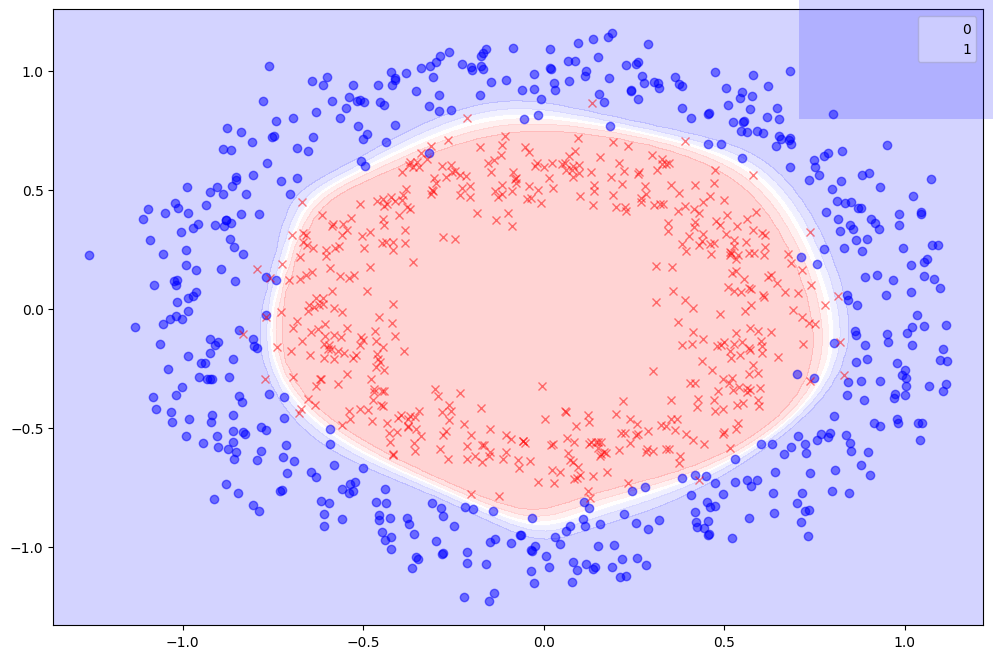

In [26]:
#   deep_circles.py
#   Defines a network that can find separate circles of data
#

#   Imports
from sklearn.datasets import make_circles
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"

#   Helper functions

#   plot the data on a figure
def plot_data(pl, X, y):
    # plot class where y==0
    pl.plot(X[y==0, 0], X[y==0,1], 'ob', alpha=0.5)
    # plot class where y==1
    pl.plot(X[y==1, 0], X[y==1,1], 'xr', alpha=0.5)
    pl.legend(['0', '1'])
    return pl

#   Common function that draws the decision boundaries
def plot_decision_boundary(model, X, y):

    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)

    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]

    # make prediction with the model and reshape the output so contourf can plot it
    c = model.predict(ab)
    Z = c.reshape(aa.shape)

    plt.figure(figsize=(12, 8))
    # plot the contour
    plt.contourf(aa, bb, Z, cmap='bwr', alpha=0.2)
    # plot the moons of data
    plot_data(plt, X, y)

    return plt


# Generate some data blobs.  Data will be either 0 or 1 when 2 is number of centers.
# X is a [number of samples, 2] sized array. X[sample] contains its x,y position of the sample in the space
# ex: X[1] = [1.342, -2.3], X[2] = [-4.342, 2.12]
# y is a [number of samples] sized array. y[sample] contains the class index (ie. 0 or 1 when there are 2 centers)
# ex: y[1] = 0 , y[1] = 1
X, y = make_circles(n_samples=1000, factor=.6, noise=0.1, random_state=42)
#pl = plot_data(plt, X, y)
#pl.show()

# Split the data into Training and Test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the keras model
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# #   Simple Sequential model
# model = Sequential()
# model.add(Dense(4, input_shape=(2,), activation="tanh",  name="Hidden-1"))
# model.add(Dense(4, activation="tanh", name="Hidden-2"))
# #   Add a Dense Fully Connected Layer with 1 neuron.  Using input_shape = (2,) says the input will
# #       be arrays of the form (*,2).  The first dimension will be an unspecified
# #       number of batches (rows) of data.  The second dimension is 2 which are the X, Y positions of each data element.
# #       The sigmoid activation function is used to return 0 or 1, signifying the data
# #       cluster the position is predicted to belong to.
# model.add(Dense(1, activation="sigmoid", name="Output_layer"))
#
#   Implement as Functional API
from keras.models import Model
from keras.layers import Input
#
inputs = Input(shape=(2,))
#   Hidden layers
x = Dense(4, activation="tanh",  name="Hidden-1")(inputs)
x = Dense(4, activation="tanh", name="Hidden-2")(x)
#   Output Layer
o = Dense(1, activation="sigmoid", name="Output_layer")(x)
#   Create Model and specify the input and output
model = Model(inputs=inputs, outputs=o)
#   Display summary
model.summary()
#   Compile the model.  Minimize crossentopy for a binary.  Maximize for accuracy
model.compile(Adam(lr=0.05), 'binary_crossentropy', metrics=['accuracy'])
from keras.utils import plot_model
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)
#   Define early stopping callback
from keras.callbacks import EarlyStopping
my_callbacks = [EarlyStopping(monitor='val_acc', patience=5, mode='max')]
#   Fit the model with the data.  Make 100 cycles through the data.
#       Set verbose to 0 to supress progress messages
model.fit(X_train, y_train, epochs=100, verbose=1, callbacks=my_callbacks, validation_data=(X_test, y_test) )
#   Get loss and accuracy on test data
eval_result = model.evaluate(X_test, y_test)
#   Print test accuracy
print("\n\nTest loss:", eval_result[0], "Test accuracy:", eval_result[1])
#   Plot the decision boundary
plot_decision_boundary(model, X, y).show()

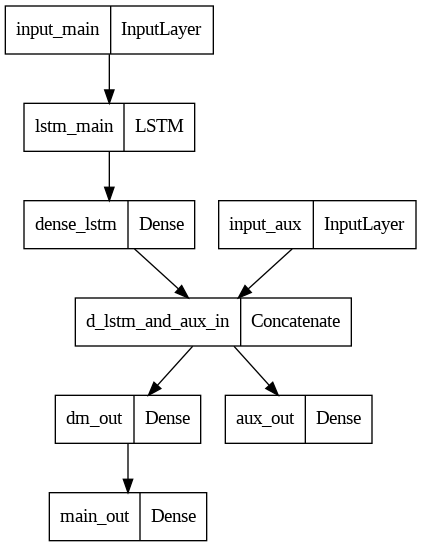

In [27]:
#   Demonstrates multiple input and output using the Functional API

from keras.layers import Input, Embedding, LSTM, Dense, concatenate
from keras.models import Model
from keras.utils import plot_model

im = Input(shape=(100,200), name='input_main')    # Main Input
ls = LSTM(10, name='lstm_main')(im)
dl = Dense(5, activation='relu', name='dense_lstm')(ls)

ix = Input(shape=(5,), name='input_aux')             # Aux Input
cc = concatenate([dl, ix], name='d_lstm_and_aux_in')
x = Dense(32, activation='relu', name='dm_out')(cc)
mo = Dense(1, activation='sigmoid', name='main_out')(x)

ao = Dense(2, name='aux_out')(cc)

model = Model(inputs=[im, ix],
                outputs=[mo, ao])

plot_model(model, to_file='model.png', show_shapes=False)

**Final Improved Fashion MNIST Model using all the above points**

In [ ]:
#Additional Example
#   Train a ConvNet on the MNIST fashion data.  This data consists of 10 classes of fashion images such
#   as shorts, dresses, shoes, purses, etc.  These images replace the handwritten digits in the classic MNIST dataset.
#   This change makes it harder to get a high score and more closely reflects real world usage of image
#   classification.  And at the same time, is still small enough for the average PC to train in a short time.
# See https://github.com/zalandoresearch/fashion-mnist for information and code on Fashion MNIST

# This code is based on MNIST example found at Keras.io

from __future__ import print_function
import keras
from keras.datasets import fashion_mnist  # new with Keras 2.1.2.  Yah!!
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

#   Supress warning and informational messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Number of classes - do not change unless the data changes
num_classes = 10

# sizes of batch and # of epochs of data
batch_size = 128
epochs = 24

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

#   Deal with format issues between different backends.  Some put the # of channels in the image before the width and height of image.
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = X_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

#   Type convert and scale the test and training data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
#print('x_train shape:', x_train.shape)
#print('x_test shape:', x_test.shape)

#print(y_train[:4])
# convert class vectors to binary class matrices.  One-hot encoding
#  3 => 0 0 0 1 0 0 0 0 0 0 and 1 => 0 1 0 0 0 0 0 0 0 0
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
#print(y_train[:4])   # verify one-hot encoding

# Define the model
model = Sequential()
# V1
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

# V2
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))


# #V3
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape))
# #model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

# #V3
# model.add(Conv2D(64, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

#V4 - remove 1st max pool
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


#   define compile to minimize categorical loss, use ada delta optimized, and optimize to maximizing accuracy
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

#   Train the model and test/validate the mode with the test data after each cycle (epoch) through the training data
#   Return history of loss and accuracy for each epoch
hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
# Train with other optimization inputs
#   Train
BATCH_SIZE = 24
EPOCHS = 5
cbk_early_stopping = EarlyStopping(monitor='val_acc', patience=2, mode='max')
model.fit(x_train, y_train, BATCH_SIZE, epochs=EPOCHS,
            validation_data=(x_test, y_test),
            callbacks=[cbk_early_stopping] )

score, acc = model.evaluate(x_test, y_test,
                            batch_size=BATCH_SIZE)
print('test score:', score, ' test accuracy:', acc)

#   Evaluate the model with the test data to get the scores on "real" data.
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#   Plot data to see relationships in training and validation data
import numpy as np
import matplotlib.pyplot as plt
epoch_list = list(range(1, len(hist.history['acc']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist.history['acc'], epoch_list, hist.history['val_acc'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.show()

In [ ]:
#
#   This program will classify reviews from IMDB based on sentiment, positive or
#   negative.  We will used the IMDB database that comes with Keras.
#   This data has already preprocessed the reviews.  This preprocessing
#   replaces the actual works with the encoding.  So the second most
#   popular word is replaced by 2, third most popular by 3, etc.

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping
from keras.datasets import imdb

#   Supress warning and informational messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#   Set parameters for data to use
NUM_WORDS = 6000        # the top most n frequent words to consider
SKIP_TOP = 2            # Skip the top most words that are likely (the, and, a)
MAX_REVIEW_LEN = 100    # Max number of words from a review.

#   Load pre-processed sentiment classified review data from IMDB Database
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = NUM_WORDS,
                                        skip_top=SKIP_TOP)
#   Print a sample
#  returns word index vector (ex. [2, 4, 2, 2, 33, 2804, ...]) and class (0 or 1)
print("encoded word sequence:", x_train[3], "class:", y_train[3])


#   Pad and truncate the review word sequences so they are all the same length
x_train = sequence.pad_sequences(x_train, maxlen = MAX_REVIEW_LEN)
x_test = sequence.pad_sequences(x_test, maxlen = MAX_REVIEW_LEN)
print('x_train.shape:', x_train.shape, 'x_test.shape:', x_test.shape)

#   The Model
model = Sequential()
model.add(Embedding(NUM_WORDS, 64 ))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))

#   Compile
model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

#   Train
BATCH_SIZE = 24
EPOCHS = 5
cbk_early_stopping = EarlyStopping(monitor='val_acc', patience=2, mode='max')
model.fit(x_train, y_train, BATCH_SIZE, epochs=EPOCHS,
            validation_data=(x_test, y_test),
            callbacks=[cbk_early_stopping] )

score, acc = model.evaluate(x_test, y_test,
                            batch_size=BATCH_SIZE)
print('test score:', score, ' test accuracy:', acc)